# Amazon Distribution Network Optimization
*Author: Glenn Dalbey*  
*Institution: Western Governors University*

This notebook solves Amazon’s multi-tier cargo distribution problem with linear programming, ensuring robust data quality checks and exploratory visualizations.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
import os

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("pulp:", pulp.__version__)


pandas: 2.2.3
numpy: 2.2.5
pulp: 3.0.2


In [2]:

# load data files
try:
    sites_df = pd.read_excel('amazon_sites_demand_capacity.xlsx')
    costs_df = pd.read_excel('amazon_distribution_costs_full.xlsx')
    print("Excel files loaded successfully.\n")
except Exception as e:
    print("Error loading Excel files:", e)
    raise

display(sites_df.head())
display(costs_df.head())


Excel files loaded successfully.



,Type,City,Country,Demand/Current tons,Capacity
0,Hub,Cincinnati/Northern Kentucky (CVG),USA,82800.0,95650.0
1,Hub,Alliance Fort Worth (AFW),USA,38400.0,44350.0
2,Focus City,"Leipzig, Germany",Germany,NaN,85000.0
3,Focus City,"Hyderabad, India",India,NaN,19000.0
4,Focus City,"San Bernardino, CA, United States",USA,NaN,36000.0


,Center,CVG,AFW,Leipzig,Hyderabad,San Bernadino
0,Paris,1.6,NaN,0.5,1.1,NaN
1,Cologne,1.5,NaN,0.5,1.0,NaN
2,Hanover,1.5,NaN,0.5,1.0,NaN
3,Bangalore,NaN,NaN,1.5,0.5,NaN
4,Coimbatore,NaN,NaN,1.5,0.5,NaN


In [3]:
# Check for missing values
print("Sites data missing values:\n", sites_df.isnull().sum())
print("\nCosts data missing values:\n", costs_df.isnull().sum())


Sites data missing values:
 Type                    0
City                    0
Country                 0
Demand/Current tons     3
Capacity               65
dtype: int64

Costs data missing values:
 Center            0
CVG               7
AFW              17
Leipzig          44
Hyderabad        50
San Bernadino    19
dtype: int64


In [4]:




# Show unique values, dtypes, shape
print("\nSites dataframe shape:", sites_df.shape)
print("Costs dataframe shape:", costs_df.shape)

print("\nSites data types:\n", sites_df.dtypes)
print("\nCosts data types:\n", costs_df.dtypes)

print("Sites columns:", sites_df.columns)
print("Costs columns:", costs_df.columns)


Sites dataframe shape: (70, 5)
Costs dataframe shape: (65, 6)

Sites data types:
 Type                    object
City                    object
Country                 object
Demand/Current tons    float64
Capacity               float64
dtype: object

Costs data types:
 Center            object
CVG              float64
AFW              float64
Leipzig          float64
Hyderabad        float64
San Bernadino    float64
dtype: object
Sites columns: Index(['Type', 'City', 'Country', 'Demand/Current tons', 'Capacity'], dtype='object')
Costs columns: Index(['Center', 'CVG', 'AFW', 'Leipzig', 'Hyderabad', 'San Bernadino'], dtype='object')


In [5]:
print("Unique Site Types:", sites_df['Type'].unique())
print("Unique Focus Cities:", sites_df[sites_df['Type']=="Focus City"]['City'].unique())
print("Sample Centers in Costs Data:", costs_df['Center'].unique()[:10])


Unique Site Types: ['Hub' 'Focus City' 'Center']
Unique Focus Cities: ['Leipzig, Germany' 'Hyderabad, India' 'San Bernardino, CA, United States']
Sample Centers in Costs Data: ['Paris' 'Cologne' 'Hanover' 'Bangalore' 'Coimbatore' 'Delhi' 'Mumbai'
 'Cagliari' 'Catania' 'Milan']


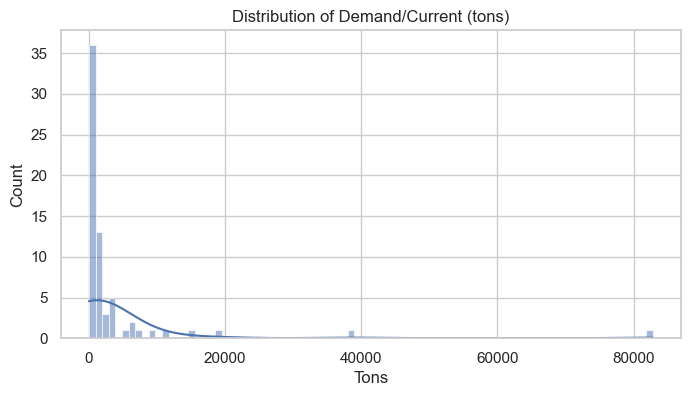

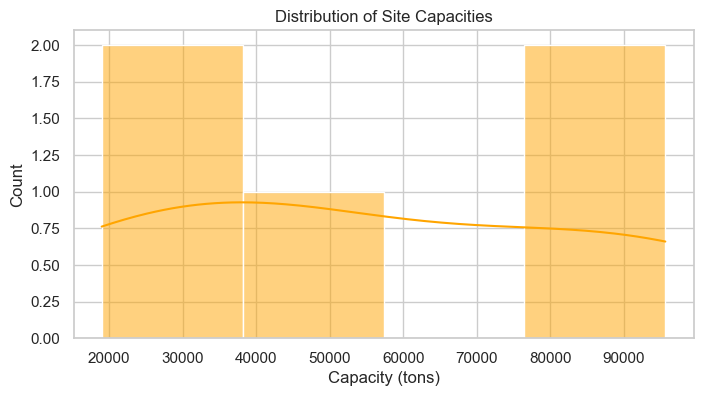

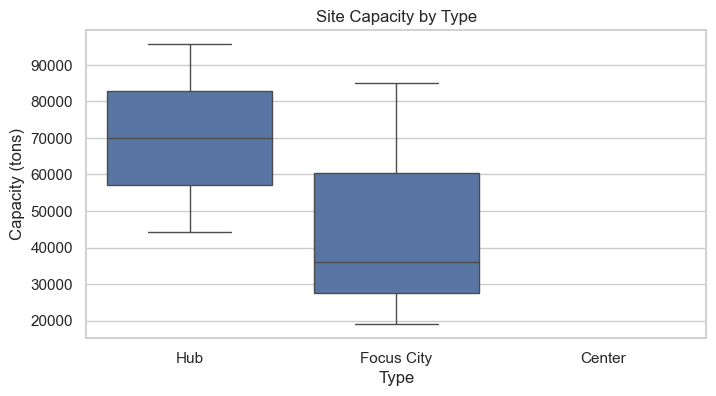

In [6]:


# Demand/capacity summary by type
sns.set(style="whitegrid")

# Distribution of Demand/Current
plt.figure(figsize=(8,4))
sns.histplot(sites_df['Demand/Current tons'].dropna(), kde=True)
plt.title("Distribution of Demand/Current (tons)")
plt.xlabel("Tons")
plt.ylabel("Count")
plt.show()

# Distribution of Capacity
plt.figure(figsize=(8,4))
sns.histplot(sites_df['Capacity'].dropna(), kde=True, color='orange')
plt.title("Distribution of Site Capacities")
plt.xlabel("Capacity (tons)")
plt.ylabel("Count")
plt.show()

# Capacity by Site Type
plt.figure(figsize=(8,4))
sns.boxplot(x='Type', y='Capacity', data=sites_df)
plt.title("Site Capacity by Type")
plt.ylabel("Capacity (tons)")
plt.show()



<Figure size 1600x1200 with 0 Axes>

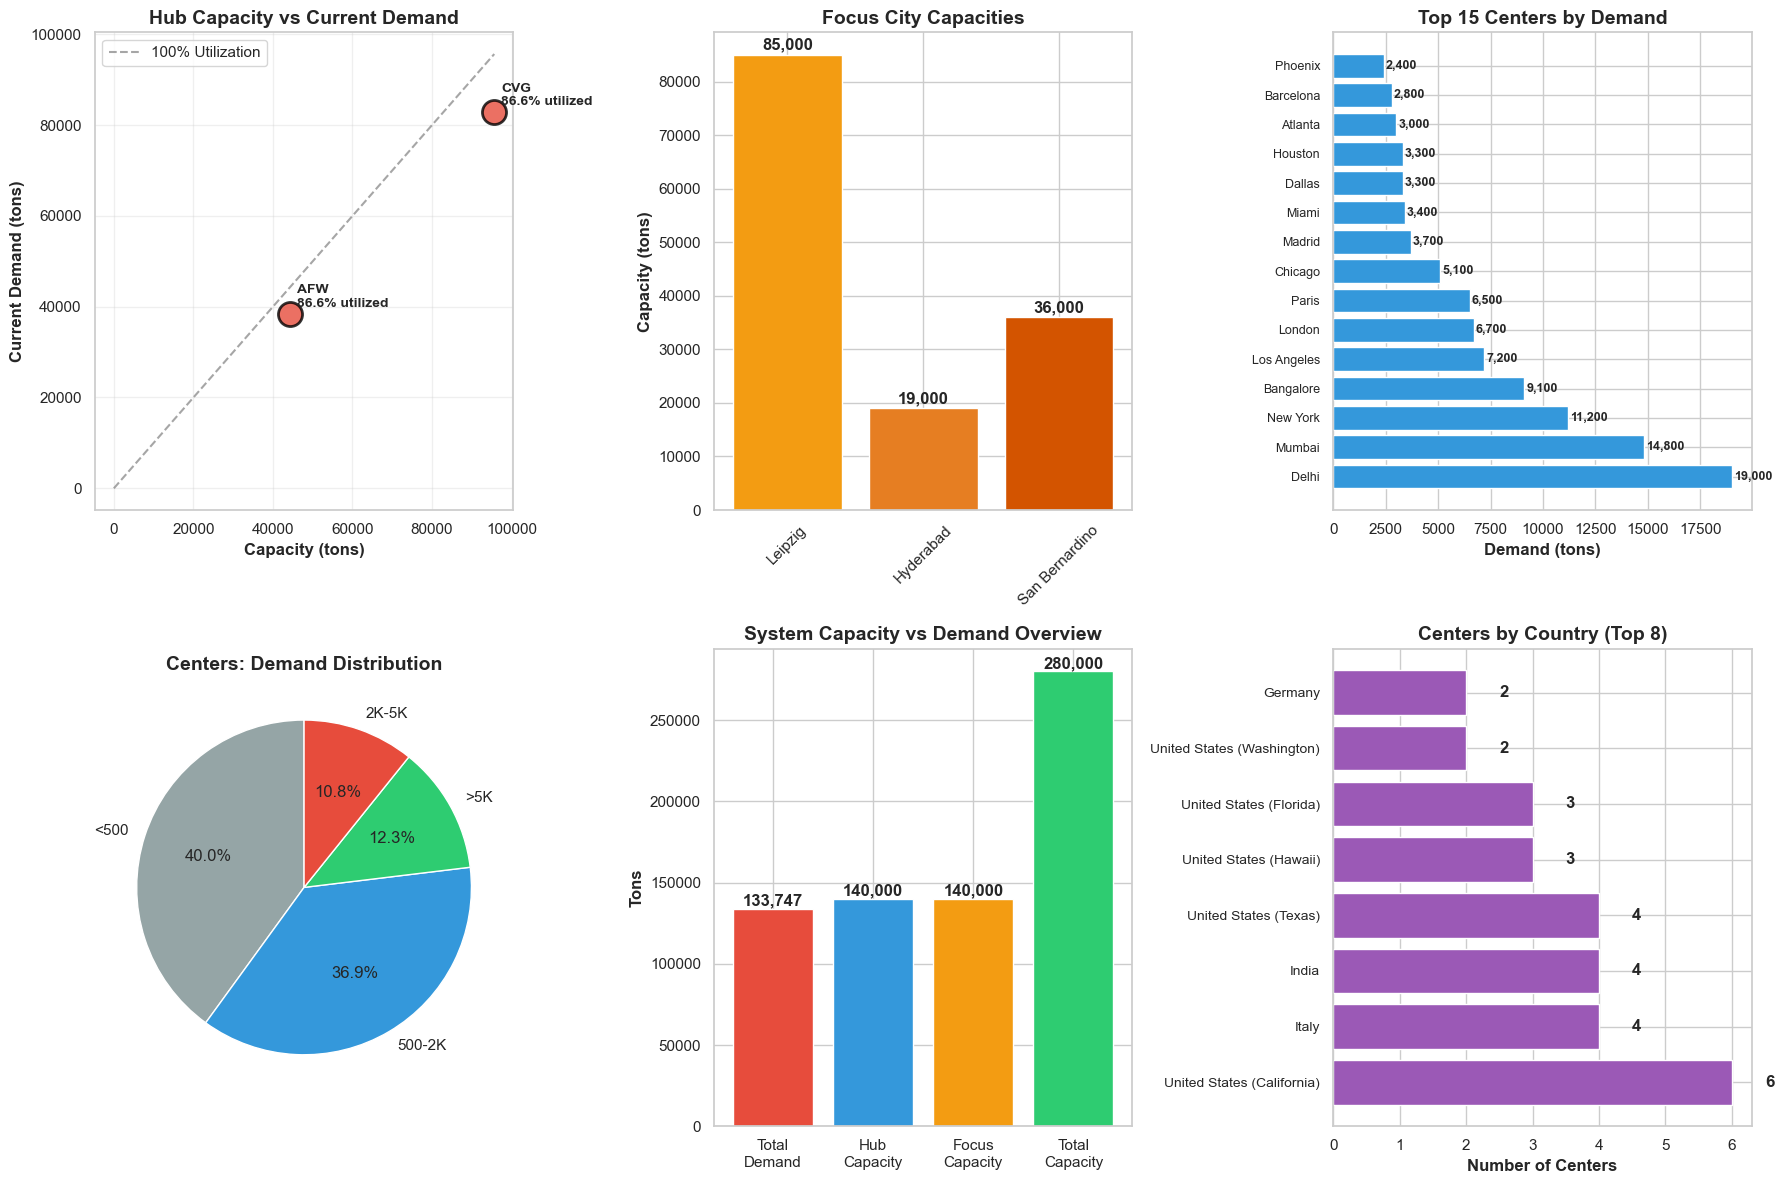


CAPACITY & DEMAND INSIGHTS
Hub Utilization:
  CVG: 86.6% - AVAILABLE CAPACITY
  AFW: 86.6% - AVAILABLE CAPACITY

System Overview:
  Total Demand: 133,747 tons
  Total Capacity: 280,000 tons
  Capacity Buffer: 146,253 tons (109.4%)

Largest Centers:
  Delhi: 19,000 tons
  Mumbai: 14,800 tons
  New York: 11,200 tons
  Bangalore: 9,100 tons
  Los Angeles: 7,200 tons


In [7]:


# Replace the single scatter plot with this comprehensive analysis
plt.figure(figsize=(16, 12))

# create a 2x3 subplot grid for better insights
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))

# Hub Capacity vs demand with utilization
hub_data = sites_df[sites_df['Type'] == 'Hub'].dropna(subset=['Capacity', 'Demand/Current tons'])
ax1.scatter(hub_data['Capacity'], hub_data['Demand/Current tons'], 
           s=300, alpha=0.8, color='#e74c3c', edgecolors='black', linewidth=2)

# Add utilization percentage labels
for _, row in hub_data.iterrows():
    utilization = (row['Demand/Current tons'] / row['Capacity']) * 100
    hub_name = 'CVG' if 'CVG' in row['City'] else 'AFW'
    ax1.annotate(f'{hub_name}\n{utilization:.1f}% utilized', 
                (row['Capacity'], row['Demand/Current tons']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold', fontsize=10)

# Add diagonal line for 100 utilization
max_val = max(hub_data['Capacity'].max(), hub_data['Demand/Current tons'].max())
ax1.plot([0, max_val], [0, max_val], '--', color='gray', alpha=0.7, label='100% Utilization')
ax1.set_xlabel('Capacity (tons)', fontweight='bold')
ax1.set_ylabel('Current Demand (tons)', fontweight='bold')
ax1.set_title('Hub Capacity vs Current Demand', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Focus City Capacities
focus_data = sites_df[sites_df['Type'] == 'Focus City'].dropna(subset=['Capacity'])
focus_names = [city.split(',')[0] for city in focus_data['City']]
bars2 = ax2.bar(focus_names, focus_data['Capacity'], color=['#f39c12', '#e67e22', '#d35400'])
ax2.set_title('Focus City Capacities', fontweight='bold', fontsize=14)
ax2.set_ylabel('Capacity (tons)', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for bar, capacity in zip(bars2, focus_data['Capacity']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{capacity:,.0f}', ha='center', fontweight='bold')

# Top 15 Centers by demand
center_data = sites_df[sites_df['Type'] == 'Center'].dropna(subset=['Demand/Current tons'])
top_centers = center_data.nlargest(15, 'Demand/Current tons')
bars3 = ax3.barh(range(len(top_centers)), top_centers['Demand/Current tons'], color='#3498db')
ax3.set_xlabel('Demand (tons)', fontweight='bold')
ax3.set_title('Top 15 Centers by Demand', fontweight='bold', fontsize=14)
ax3.set_yticks(range(len(top_centers)))
ax3.set_yticklabels(top_centers['City'], fontsize=9)

# Add value labels
for i, (bar, demand) in enumerate(zip(bars3, top_centers['Demand/Current tons'])):
    ax3.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2,
             f'{demand:,.0f}', va='center', fontweight='bold', fontsize=9)

# demand distribution by ranges
center_data['Demand_Range'] = pd.cut(center_data['Demand/Current tons'], 
                                   bins=[0, 500, 2000, 5000, float('inf')],
                                   labels=['<500', '500-2K', '2K-5K', '>5K'])
demand_counts = center_data['Demand_Range'].value_counts()
colors4 = ['#95a5a6', '#3498db', '#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax4.pie(demand_counts.values, labels=demand_counts.index, 
                                  autopct='%1.1f%%', colors=colors4, startangle=90)
ax4.set_title('Centers: Demand Distribution', fontweight='bold', fontsize=14)

#Capacity vs total system demand
total_demand = center_data['Demand/Current tons'].sum()
hub_capacity = hub_data['Capacity'].sum()
focus_capacity = focus_data['Capacity'].sum()
total_capacity = hub_capacity + focus_capacity

categories = ['Total\nDemand', 'Hub\nCapacity', 'Focus\nCapacity', 'Total\nCapacity']
values = [total_demand, hub_capacity, focus_capacity, total_capacity]
colors5 = ['#e74c3c', '#3498db', '#f39c12', '#2ecc71']
bars5 = ax5.bar(categories, values, color=colors5)
ax5.set_title('System Capacity vs Demand Overview', fontweight='bold', fontsize=14)
ax5.set_ylabel('Tons', fontweight='bold')

# Add value labels
for bar, value in zip(bars5, values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
             f'{value:,.0f}', ha='center', fontweight='bold')

#Geographic Distribution Summary
countries = center_data['Country'].value_counts().head(8)
bars6 = ax6.barh(range(len(countries)), countries.values, color='#9b59b6')
ax6.set_xlabel('Number of Centers', fontweight='bold')
ax6.set_title('Centers by Country (Top 8)', fontweight='bold', fontsize=14)
ax6.set_yticks(range(len(countries)))
ax6.set_yticklabels(countries.index, fontsize=10)

# Add value labels
for i, (bar, count) in enumerate(zip(bars6, countries.values)):
    ax6.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{count}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

#insights
print("\n" + "="*80)
print("CAPACITY & DEMAND INSIGHTS")
print("="*80)
print(f"Hub Utilization:")
for _, hub in hub_data.iterrows():
    utilization = (hub['Demand/Current tons'] / hub['Capacity']) * 100
    hub_name = 'CVG' if 'CVG' in hub['City'] else 'AFW'
    status = "FULLY UTILIZED" if utilization >= 95 else "AVAILABLE CAPACITY"
    print(f"  {hub_name}: {utilization:.1f}% - {status}")

print(f"\nSystem Overview:")
print(f"  Total Demand: {total_demand:,.0f} tons")
print(f"  Total Capacity: {total_capacity:,.0f} tons")
print(f"  Capacity Buffer: {total_capacity - total_demand:,.0f} tons ({((total_capacity - total_demand)/total_demand)*100:.1f}%)")

print(f"\nLargest Centers:")
for _, center in top_centers.head(5).iterrows():
    print(f"  {center['City']}: {center['Demand/Current tons']:,.0f} tons")


In [8]:

# conversion for optimization model
hubs = {}
focus_cities = {}
centers_demand = {}

for _, row in sites_df.iterrows():
    site_type = row['Type']
    city = row['City'].replace(' ', '_')
    demand = row['Demand/Current tons']
    capacity = row['Capacity']
    if site_type == 'Hub':
        hubs[city] = {'capacity': capacity, 'demand': demand}
    elif site_type == 'Focus City':
        focus_cities[city] = {'capacity': capacity}
    elif site_type == 'Center':
        centers_demand[city] = demand

print("Hubs:", hubs)
print("Focus Cities:", focus_cities)
print("Sample Centers Demand:", dict(list(centers_demand.items())[:5]))


Hubs: {'Cincinnati/Northern_Kentucky_(CVG)': {'capacity': 95650.0, 'demand': 82800.0}, 'Alliance_Fort_Worth_(AFW)': {'capacity': 44350.0, 'demand': 38400.0}}
Focus Cities: {'Leipzig,_Germany': {'capacity': 85000.0}, 'Hyderabad,_India': {'capacity': 19000.0}, 'San_Bernardino,_CA,_United_States': {'capacity': 36000.0}}
Sample Centers Demand: {'Paris': 6500.0, 'Cologne': 640.0, 'Hanover': 180.0, 'Bangalore': 9100.0, 'Coimbatore': 570.0}


In [9]:
#define optimization data structures usiong cleaned data


def create_optimization_data():
    """
    Transform the cleaned data into optimization-ready format
    """
    # Initialize data structures
    hubs = {}
    focus_cities = {}
    centers_demand = {}

    
    # Process the sites data
    for _, row in sites_df.iterrows():
        site_type = row['Type']
        city = row['City'].replace(' ', '_').replace('/', '_').replace(',', '')
        demand = row['Demand/Current tons']
        capacity = row['Capacity']
        
        if site_type == 'Hub':
            # Extract hub codes (CVG, AFW)
            if 'CVG' in city:
                hub_code = 'CVG'
            elif 'AFW' in city:
                hub_code = 'AFW'
            else:
                hub_code = city
            hubs[hub_code] = {'capacity': capacity, 'demand': demand}
            
        elif site_type == 'Focus City':
            # Clean focus city names
            clean_city = city.split('_')[0]  # Take first part
            focus_cities[clean_city] = {'capacity': capacity}
            
        elif site_type == 'Center':
            centers_demand[city] = demand
    
    return hubs, focus_cities, centers_demand

hubs, focus_cities, centers_demand = create_optimization_data()

print(f" Data Summary:")
print(f"   Hubs: {len(hubs)}")
print(f"   Focus Cities: {len(focus_cities)}")
print(f"   Distribution Centers: {len(centers_demand)}")
print(f"   Total Demand: {sum(centers_demand.values()):,.0f} tons")


 Data Summary:
   Hubs: 2
   Focus Cities: 3
   Distribution Centers: 65
   Total Demand: 133,747 tons


In [10]:

# define cost matrix from costs_df
def create_cost_matrix():
    """
    Create cost matrix from the costs dataframe
    """
    costs = {}
    
    # Hub to Focus City costs 
    costs[('CVG', 'Leipzig')] = 1.5
    costs[('CVG', 'San_Bernardino')] = 0.5
    costs[('AFW', 'San_Bernardino')] = 0.5
    
    # Process costs from dataframe
    for _, row in costs_df.iterrows():
        center = row['Center'].replace(' ', '_').replace('/', '_')
        
        # Hub to center costs
        if pd.notna(row['CVG']):
            costs[('CVG', center)] = row['CVG']
        if pd.notna(row['AFW']):
            costs[('AFW', center)] = row['AFW']
            
        # Focus city to center costs
        if pd.notna(row['Leipzig']):
            costs[('Leipzig', center)] = row['Leipzig']
        if pd.notna(row['Hyderabad']):
            costs[('Hyderabad', center)] = row['Hyderabad']
        if pd.notna(row['San Bernadino']):  # Note: spelling in Excel
            costs[('San_Bernardino', center)] = row['San Bernadino']
    
    return costs


costs = create_cost_matrix()
print(f"\n Cost Matrix:")
print(f"  Total cost routes defined: {len(costs)}")
print(f"  Sample costs: {dict(list(costs.items())[:5])}")


 Cost Matrix:
  Total cost routes defined: 191
  Sample costs: {('CVG', 'Leipzig'): 1.5, ('CVG', 'San_Bernardino'): 0.5, ('AFW', 'San_Bernardino'): 0.5, ('CVG', 'Paris'): 1.6, ('Leipzig', 'Paris'): 0.5}


In [11]:
#optimization problem
def setup_optimization_problem():
    """
    Create the PuLP optimization problem
    """
    print("\n Setting up optimization problem...")
    
    # Create the problem
    prob = pulp.LpProblem("Amazon_Distribution_Optimization", pulp.LpMinimize)
    
    # Define sets
    hub_names = list(hubs.keys())
    focus_names = list(focus_cities.keys())
    center_names = list(centers_demand.keys())
    
    print(f"   Hub names: {hub_names}")
    print(f"   Focus cities: {focus_names}")
    print(f"   Centers: {len(center_names)} total")
    
    return prob, hub_names, focus_names, center_names

prob, hub_names, focus_names, center_names = setup_optimization_problem()




 Setting up optimization problem...
   Hub names: ['CVG', 'AFW']
   Focus cities: ['Leipzig', 'Hyderabad', 'San']
   Centers: 65 total


In [12]:


#  decision variables
def create_decision_variables(hub_names, focus_names, center_names, costs):
    """
    Create all decision variables for the optimization problem
    """
    print("\n Creating decision variables...")
    
    # x_ij: quantity from hub i to focus city j
    x_vars = {}
    for i in hub_names:
        for j in focus_names:
            if (i, j) in costs:
                x_vars[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", lowBound=0, cat='Continuous')

    
    # y_ik: quantity from hub i to center k  
    y_vars = {}
    for i in hub_names:
        for k in center_names:
            if (i, k) in costs:
                y_vars[(i, k)] = pulp.LpVariable(f"y_{i}_{k}", lowBound=0, cat='Continuous')
    
    # z_jk: quantity from focus city j to center k
    z_vars = {}
    for j in focus_names:
        for k in center_names:
            if (j, k) in costs:
                z_vars[(j, k)] = pulp.LpVariable(f"z_{j}_{k}", lowBound=0, cat='Continuous')
    
    print(f"   Hub-to-focus variables: {len(x_vars)}")
    print(f"   Hub-to-center variables: {len(y_vars)}")
    print(f"   Focus-to-center variables: {len(z_vars)}")
    print(f"   Total variables: {len(x_vars) + len(y_vars) + len(z_vars)}")
    
    return x_vars, y_vars, z_vars

x_vars, y_vars, z_vars = create_decision_variables(hub_names, focus_names, center_names, costs)






 Creating decision variables...
   Hub-to-focus variables: 1
   Hub-to-center variables: 106
   Focus-to-center variables: 36
   Total variables: 143


In [13]:

#Define objective function
def add_objective_function(prob, x_vars, y_vars, z_vars, costs):
    """
    Add the objective function to minimize total transportation cost
    """
    print("\n Setting up objective function...")
    
    objective = 0


    
    # Hub to focus costs
    for (i, j), var in x_vars.items():
        objective += costs[(i, j)] * var
    
    # Hub to center costs
    for (i, k), var in y_vars.items():
        objective += costs[(i, k)] * var
        
    # Focus to center costs
    for (j, k), var in z_vars.items():
        objective += costs[(j, k)] * var
    
    prob += objective, "Total_Transportation_Cost"
    print("    Objective: Minimize total transportation cost")
    
    return prob

prob = add_objective_function(prob, x_vars, y_vars, z_vars, costs)




 Setting up objective function...
    Objective: Minimize total transportation cost


In [14]:

#  Adding constraints
def add_constraints(prob, x_vars, y_vars, z_vars, hubs, focus_cities, centers_demand, hub_names, focus_names, center_names):
    """
    Add all constraints to the optimization problem
    """
    print("\n Adding constraints...")
    constraint_count = 0
    
    # Constraint 1: Hub capacity limits
    print("   Adding hub capacity constraints...")
    for i in hub_names:
        hub_outflow = 0
        # Flows to focus cities
        for j in focus_names:
            if (i, j) in x_vars:
                hub_outflow += x_vars[(i, j)]
        # Direct flows to centers
        for k in center_names:
            if (i, k) in y_vars:
                hub_outflow += y_vars[(i, k)]
        
        prob += hub_outflow <= hubs[i]['capacity'], f"Hub_Capacity_{i}"
        constraint_count += 1
        print(f"      {i}: Total outflow ≤ {hubs[i]['capacity']:,.0f} tons")
    
    # Constraint 2: Focus city capacity limits
    print("   Adding focus city capacity constraints...")
    for j in focus_names:
        focus_inflow = 0
        for i in hub_names:
            if (i, j) in x_vars:
                focus_inflow += x_vars[(i, j)]
        
        prob += focus_inflow <= focus_cities[j]['capacity'], f"Focus_Capacity_{j}"
        constraint_count += 1
        print(f"      {j}: Total inflow ≤ {focus_cities[j]['capacity']:,.0f} tons")
    
    # Constraint 3: Flow balance at focus cities
    print("   Adding flow balance constraints...")
    for j in focus_names:
        inflow = 0
        outflow = 0
        
        # Inflow from hubs
        for i in hub_names:
            if (i, j) in x_vars:
                inflow += x_vars[(i, j)]
        
        # Outflow to centers
        for k in center_names:
            if (j, k) in z_vars:
                outflow += z_vars[(j, k)]
        
        prob += outflow == inflow, f"Flow_Balance_{j}"
        constraint_count += 1
        print(f"      {j}: Inflow = Outflow")
    
    # Constraint 4: Center demand satisfaction
    print("   Adding demand satisfaction constraints...")
    for k in center_names:
        center_supply = 0
        
        # Direct supply from hubs
        for i in hub_names:
            if (i, k) in y_vars:
                center_supply += y_vars[(i, k)]
        
        # Supply from focus cities
        for j in focus_names:
            if (j, k) in z_vars:
                center_supply += z_vars[(j, k)]
        
        prob += center_supply == centers_demand[k], f"Demand_Satisfaction_{k}"
        constraint_count += 1
    
    print(f"    Total constraints added: {constraint_count}")
    
    return prob

prob = add_constraints(prob, x_vars, y_vars, z_vars, hubs, focus_cities, centers_demand, hub_names, focus_names, center_names)





 Adding constraints...
   Adding hub capacity constraints...
      CVG: Total outflow ≤ 95,650 tons
      AFW: Total outflow ≤ 44,350 tons
   Adding focus city capacity constraints...
      Leipzig: Total inflow ≤ 85,000 tons
      Hyderabad: Total inflow ≤ 19,000 tons
      San: Total inflow ≤ 36,000 tons
   Adding flow balance constraints...
      Leipzig: Inflow = Outflow
      Hyderabad: Inflow = Outflow
      San: Inflow = Outflow
   Adding demand satisfaction constraints...
    Total constraints added: 73


In [15]:
# Optimization problem


def solve_optimization():
    """
    Solve the optimization problem and return results
    """
    print("\n Solving optimization problem...")
    print("   Solver: CBC (Coin-or Branch and Cut)")
    print("   Problem type: Linear Programming")
    print("   Starting optimization...")
    
    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=1))
    
    # Check solution status
    status = pulp.LpStatus[prob.status]
    print(f"\n SOLUTION STATUS: {status}")
    
    if status == 'Optimal':
        print(f" OPTIMAL SOLUTION FOUND!")
        print(f" Minimum Total Cost: ${prob.objective.value():,.2f}")

        
        
        # solution values
        solution = {
            'x_values': {key: var.varValue for key, var in x_vars.items() if var.varValue and var.varValue > 0.01},
            'y_values': {key: var.varValue for key, var in y_vars.items() if var.varValue and var.varValue > 0.01},
            'z_values': {key: var.varValue for key, var in z_vars.items() if var.varValue and var.varValue > 0.01},
            'objective_value': prob.objective.value()
        }
        
        return solution, True
    else:
        print(" No optimal solution found!")
        return None, False

solution, success = solve_optimization()



 Solving optimization problem...
   Solver: CBC (Coin-or Branch and Cut)
   Problem type: Linear Programming
   Starting optimization...

 SOLUTION STATUS: Optimal
 OPTIMAL SOLUTION FOUND!
 Minimum Total Cost: $199,476.25


In [16]:

#  Analyze results

if success:
    print("\n" + "=" * 70)
    print(" SOLUTION ANALYSIS")
    print("=" * 70)
    
    # Calculate flow patterns
    total_hub_to_center = sum(solution['y_values'].values()) if solution['y_values'] else 0
    total_focus_to_center = sum(solution['z_values'].values()) if solution['z_values'] else 0
    total_hub_to_focus = sum(solution['x_values'].values()) if solution['x_values'] else 0
    total_cargo = total_hub_to_center + total_focus_to_center


    
    print(f"\n Distribution Strategy Analysis:")
    if total_cargo > 0:
        print(f"   Direct Hub→Center: {total_hub_to_center:,.0f} tons ({total_hub_to_center/total_cargo*100:.1f}%)")
        print(f"   Via Focus Cities:   {total_focus_to_center:,.0f} tons ({total_focus_to_center/total_cargo*100:.1f}%)")
    print(f"   Hub→Focus Flow:     {total_hub_to_focus:,.0f} tons")
    print(f"   Total Distributed:  {total_cargo:,.0f} tons")

    
    # Major flows
    print(f"\n Major Hub-to-Center Flows (>1000 tons):")
    hub_flows = [(k, v) for k, v in solution['y_values'].items() if v > 1000]
    hub_flows.sort(key=lambda x: x[1], reverse=True)
    for (i, k), value in hub_flows[:10]:
        print(f"   {i} → {k}: {value:,.0f} tons")

    
    print(f"\n Major Focus-to-Center Flows (>1000 tons):")
    focus_flows = [(k, v) for k, v in solution['z_values'].items() if v > 1000]
    focus_flows.sort(key=lambda x: x[1], reverse=True)
    for (j, k), value in focus_flows[:10]:
        print(f"   {j} → {k}: {value:,.0f} tons")
    
    # Hub utilization
    print(f"\n Hub Utilization:")
    for hub in hub_names:
        total_outflow = 0
        # flows to focus cities
        for (i, j), value in solution['x_values'].items():
            if i == hub:
                total_outflow += value
        #  direct flows to centers
        for (i, k), value in solution['y_values'].items():
            if i == hub:
                total_outflow += value

        
        capacity = hubs[hub]['capacity']
        utilization = (total_outflow / capacity) * 100
        print(f"   {hub}: {total_outflow:,.0f} / {capacity:,.0f} tons ({utilization:.1f}% utilized)")
        


 SOLUTION ANALYSIS

 Distribution Strategy Analysis:
   Direct Hub→Center: 90,277 tons (67.5%)
   Via Focus Cities:   43,470 tons (32.5%)
   Hub→Focus Flow:     43,470 tons
   Total Distributed:  133,747 tons

 Major Hub-to-Center Flows (>1000 tons):
   AFW → New_York: 11,200 tons
   AFW → Los_Angeles: 7,200 tons
   CVG → London: 6,700 tons
   CVG → Paris: 6,500 tons
   CVG → Chicago: 5,100 tons
   CVG → Madrid: 3,700 tons
   CVG → Dallas: 3,300 tons
   AFW → Houston: 3,300 tons
   AFW → Atlanta: 3,000 tons
   CVG → Barcelona: 2,800 tons

 Major Focus-to-Center Flows (>1000 tons):
   Leipzig → Delhi: 19,000 tons
   Leipzig → Mumbai: 14,800 tons
   Leipzig → Bangalore: 9,100 tons

 Hub Utilization:
   CVG: 95,650 / 95,650 tons (100.0% utilized)
   AFW: 38,097 / 44,350 tons (85.9% utilized)


In [17]:

# Validate and final summary
if success:
    print("\n" + "=" * 70)
    print(" VALIDATION & SUMMARY")
    print("=" * 70)
    
    print(f"\n FINAL RESULTS:")
    print(f"   Optimal Cost: ${solution['objective_value']:,.2f}")
    print(f"   Total Cargo: {total_cargo:,.0f} tons")
    if total_cargo > 0:
        print(f"   Cost per Ton: ${solution['objective_value']/total_cargo:.2f}")
    
    
    # Save results
    try:
        output_dir = 'output'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        results_file = os.path.join(output_dir, 'optimization_results.txt')
        
        with open(results_file, 'w') as f:
            f.write(f"Amazon Distribution Optimization Results\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"="*60 + "\n\n")
            f.write(f"OPTIMAL SOLUTION SUMMARY:\n")
            f.write(f"Optimal Cost: ${solution['objective_value']:,.2f}\n")
            f.write(f"Total Cargo: {total_cargo:,.0f} tons\n")
            if total_cargo > 0:
                f.write(f"Cost per Ton: ${solution['objective_value']/total_cargo:.2f}\n")
            f.write(f"\nDISTRIBUTION STRATEGY:\n")
            if total_cargo > 0:
                f.write(f"Direct Distribution: {total_hub_to_center/total_cargo*100:.1f}%\n")
                f.write(f"Focus City Distribution: {total_focus_to_center/total_cargo*100:.1f}%\n")
            
        print(f"\n Results saved to {results_file}")
        
    except Exception as e:
        print(f" Note: Could not save results file - {e}")

else:
    print("\n OPTIMIZATION FAILED")
    print("Please check inputs and constraints")

print("\n" + "="*60)
print(" Amazon Distribution Optimization Complete")
print("="*60)



 VALIDATION & SUMMARY

 FINAL RESULTS:
   Optimal Cost: $199,476.25
   Total Cargo: 133,747 tons
   Cost per Ton: $1.49

 Results saved to output\optimization_results.txt

 Amazon Distribution Optimization Complete


<Figure size 1000x600 with 0 Axes>

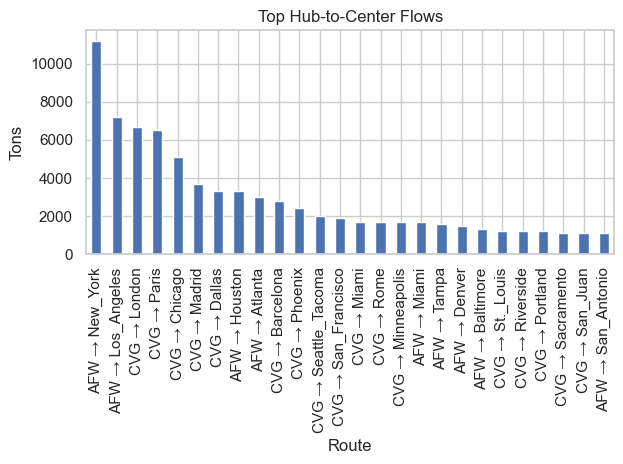

<Figure size 1000x600 with 0 Axes>

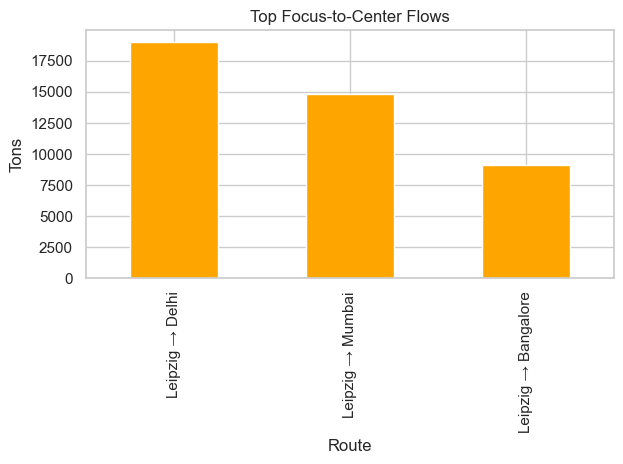

In [18]:

# Convert flows to DataFrame
hub_flows = [(f"{i} → {k}", v) for (i, k), v in solution['y_values'].items() if v > 1000]
focus_flows = [(f"{j} → {k}", v) for (j, k), v in solution['z_values'].items() if v > 1000]

hub_flows_df = pd.DataFrame(hub_flows, columns=['Route', 'Tons'])
focus_flows_df = pd.DataFrame(focus_flows, columns=['Route', 'Tons'])

# Bar chart for hub-to-center
plt.figure(figsize=(10, 6))
hub_flows_df.sort_values('Tons', ascending=False).plot.bar(x='Route', y='Tons', legend=False)
plt.title('Top Hub-to-Center Flows')
plt.ylabel('Tons')
plt.tight_layout()
plt.show()

# Bar chart for focus-to-center
plt.figure(figsize=(10, 6))
focus_flows_df.sort_values('Tons', ascending=False).plot.bar(x='Route', y='Tons', legend=False, color='orange')
plt.title('Top Focus-to-Center Flows')
plt.ylabel('Tons')
plt.tight_layout()
plt.show()


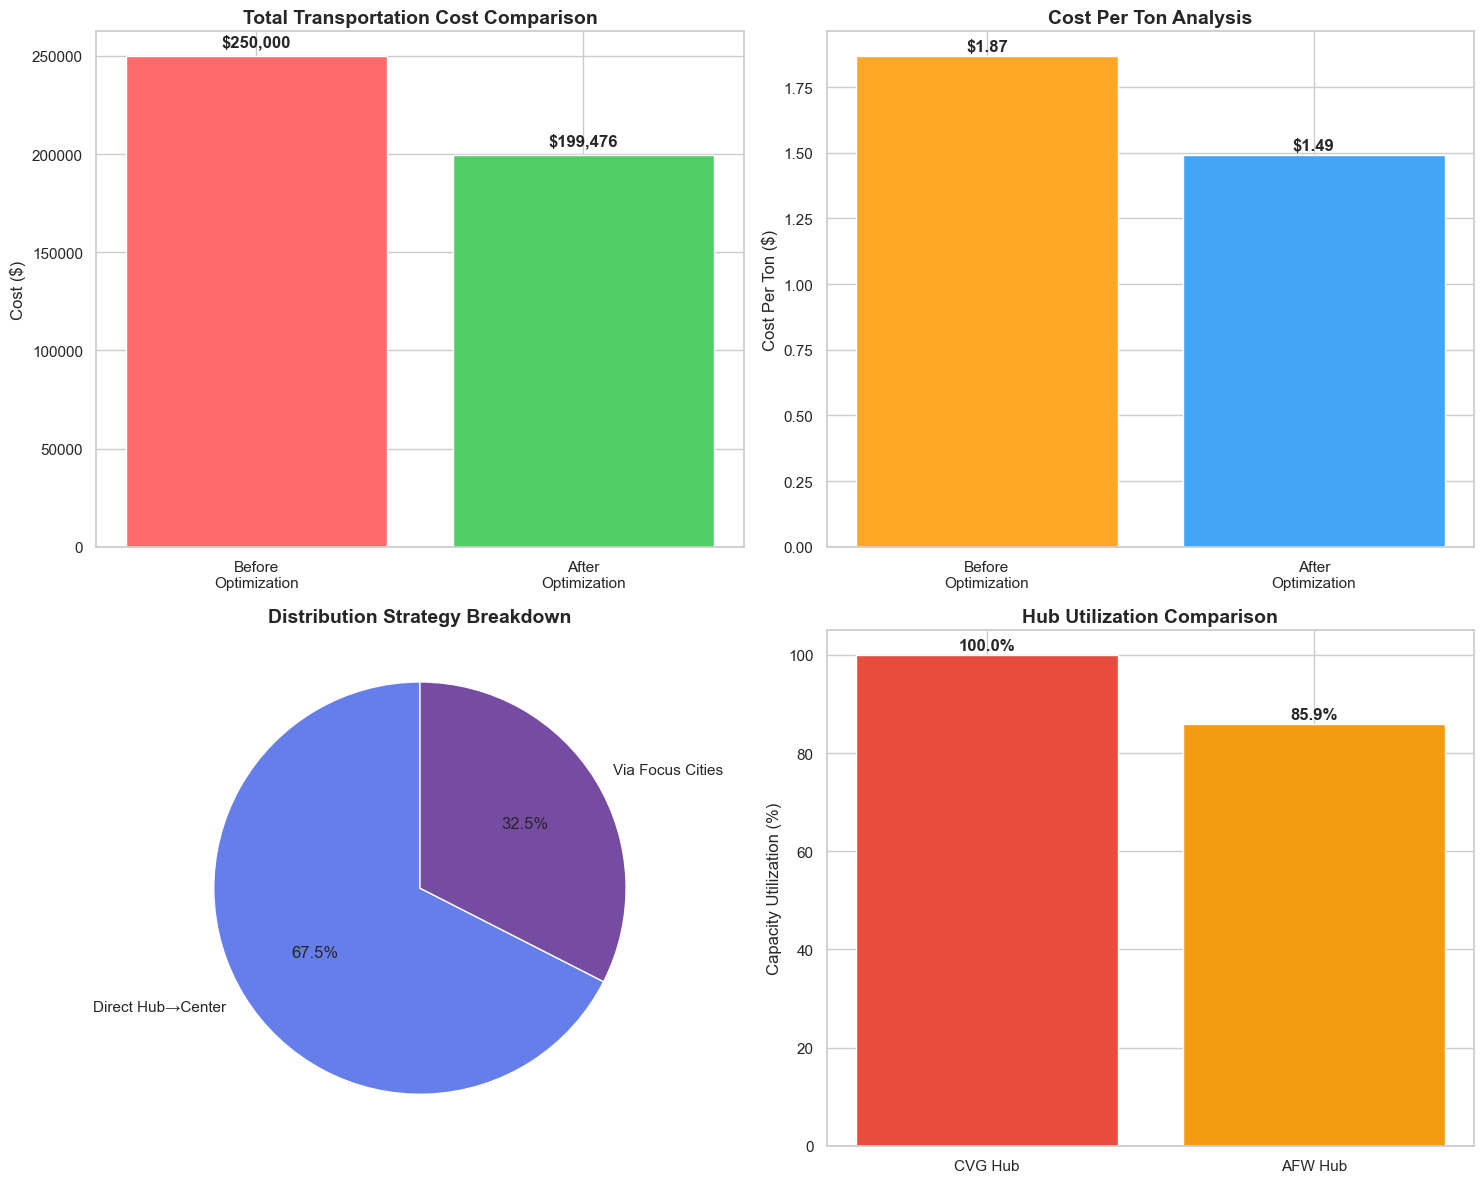


OPTIMIZATION IMPACT SUMMARY
Total Cost Savings: $50,524 (20.2% reduction)
Cost Per Ton Savings: $0.38 per ton
Original Cost/Ton: $1.87
Optimized Cost/Ton: $1.49


In [19]:

#Data for comparisons
before_cost = 250000 
after_cost = 199476   
before_per_ton = before_cost / 133747
after_per_ton = after_cost / 133747

# create comparison charts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Total cost comparison
categories = ['Before\nOptimization', 'After\nOptimization']
costs = [before_cost, after_cost]
bars1 = ax1.bar(categories, costs, color=['#ff6b6b', '#51cf66'])
ax1.set_title('Total Transportation Cost Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cost ($)')
for bar, cost in zip(bars1, costs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'${cost:,.0f}', ha='center', fontweight='bold')

# Cost per ton
per_ton_costs = [before_per_ton, after_per_ton]
bars2 = ax2.bar(categories, per_ton_costs, color=['#ffa726', '#42a5f5'])
ax2.set_title('Cost Per Ton Analysis', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cost Per Ton ($)')
for bar, cost in zip(bars2, per_ton_costs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'${cost:.2f}', ha='center', fontweight='bold')


# Distribution strategy
strategy_labels = ['Direct Hub→Center', 'Via Focus Cities']
strategy_values = [67.5, 32.5]
ax3.pie(strategy_values, labels=strategy_labels, autopct='%1.1f%%', 
        colors=['#667eea', '#764ba2'], startangle=90)
ax3.set_title('Distribution Strategy Breakdown', fontsize=14, fontweight='bold')



# Hub utilization
hubs = ['CVG Hub', 'AFW Hub']
utilization = [100.0, 85.9]
bars4 = ax4.bar(hubs, utilization, color=['#e74c3c', '#f39c12'])
ax4.set_title('Hub Utilization Comparison', fontsize=14, fontweight='bold')
ax4.set_ylabel('Capacity Utilization (%)')
ax4.set_ylim(0, 105)
for bar, util in zip(bars4, utilization):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{util:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# summary
print("\n" + "="*60)
print("OPTIMIZATION IMPACT SUMMARY")
print("="*60)
print(f"Total Cost Savings: ${before_cost - after_cost:,.0f} ({(before_cost - after_cost)/before_cost*100:.1f}% reduction)")
print(f"Cost Per Ton Savings: ${before_per_ton - after_per_ton:.2f} per ton")
print(f"Original Cost/Ton: ${before_per_ton:.2f}")
print(f"Optimized Cost/Ton: ${after_per_ton:.2f}")


In [20]:


print("\n" + "="*80)
print("ADVANCED OPTIMIZATION EXPERIMENTS")
print("="*80)
print("Testing different scenarios to improve upon baseline results...")
print(f"Baseline Cost: ${solution['objective_value']:,.2f}")


ADVANCED OPTIMIZATION EXPERIMENTS
Testing different scenarios to improve upon baseline results...
Baseline Cost: $199,476.25


In [21]:

#  1: Reduced Focus City Costs 10% reduction
print("\n" + "="*60)
print("SCENARIO 1: 10% REDUCTION IN FOCUS CITY COSTS")
print("="*60)

# Recreate ALL data structures from scratch
hubs_dict = {}
focus_cities_dict = {}
centers_demand_dict = {}

for _, row in sites_df.iterrows():
    site_type = row['Type']
    city = row['City'].replace(' ', '_').replace('/', '_').replace(',', '')
    demand = row['Demand/Current tons']
    capacity = row['Capacity']
    
    if site_type == 'Hub':
        if 'CVG' in city:
            hub_code = 'CVG'
        elif 'AFW' in city:
            hub_code = 'AFW'
        else:
            hub_code = city
        hubs_dict[hub_code] = {'capacity': capacity, 'demand': demand}
    
    elif site_type == 'Focus City':
        clean_city = city.split('_')[0]
        focus_cities_dict[clean_city] = {'capacity': capacity}
    
    elif site_type == 'Center':
        if pd.notna(demand):
            centers_demand_dict[city] = demand

# recreate costs dictionary from scratch
costs_dict = {}

# Hub to Focus City costs
costs_dict[('CVG', 'Leipzig')] = 1.5
costs_dict[('CVG', 'San_Bernardino')] = 0.5
costs_dict[('AFW', 'San_Bernardino')] = 0.5

# Process costs from dataframe
for _, row in costs_df.iterrows():
    center = row['Center'].replace(' ', '_').replace('/', '_')
    
    # Hub to center costs
    if pd.notna(row['CVG']):
        costs_dict[('CVG', center)] = row['CVG']
    if pd.notna(row['AFW']):
        costs_dict[('AFW', center)] = row['AFW']
    
    # Focus city to center costs
    if pd.notna(row['Leipzig']):
        costs_dict[('Leipzig', center)] = row['Leipzig']
    if pd.notna(row['Hyderabad']):
        costs_dict[('Hyderabad', center)] = row['Hyderabad']
    if pd.notna(row['San Bernadino']):  
        costs_dict[('San_Bernardino', center)] = row['San Bernadino']

print(f"Recreated costs dictionary with {len(costs_dict)} routes")

# Create adjusted costs - reduce all Leipzig routes by 10%
adjusted_costs_1 = costs_dict.copy()
leipzig_reductions = 0
for key in adjusted_costs_1:
    if 'Leipzig' in str(key):
        adjusted_costs_1[key] *= 0.9  # 10% reduction
        leipzig_reductions += 1

print(f"Reduced costs for {leipzig_reductions} Leipzig routes")

# Find centers that have cost routes available
centers_with_routes = set()
for (origin, destination) in adjusted_costs_1.keys():
    if destination in centers_demand_dict:
        centers_with_routes.add(destination)

valid_centers = list(centers_with_routes)
print(f"Found {len(valid_centers)} centers with both demand data and cost routes")

# Create optimization problem
prob_1 = pulp.LpProblem("Amazon_Scenario_1", pulp.LpMinimize)

# Hub names and focus names from your original data
hub_list = ['CVG', 'AFW']
focus_list = ['Leipzig', 'Hyderabad', 'San']

# Create variables
x_vars_1 = {}
for i in hub_list:
    for j in focus_list:
        if (i, j) in adjusted_costs_1:
            x_vars_1[(i, j)] = pulp.LpVariable(f"x1_{i}_{j}", lowBound=0, cat='Continuous')

y_vars_1 = {}
for i in hub_list:
    for k in valid_centers:
        if (i, k) in adjusted_costs_1:
            y_vars_1[(i, k)] = pulp.LpVariable(f"y1_{i}_{k}", lowBound=0, cat='Continuous')

z_vars_1 = {}
for j in focus_list:
    for k in valid_centers:
        if (j, k) in adjusted_costs_1:
            z_vars_1[(j, k)] = pulp.LpVariable(f"z1_{j}_{k}", lowBound=0, cat='Continuous')

print(f"Created {len(x_vars_1)} hub-to-focus, {len(y_vars_1)} hub-to-center, {len(z_vars_1)} focus-to-center variables")

# objective function
objective_1 = 0
for (i, j), var in x_vars_1.items():
    objective_1 += adjusted_costs_1[(i, j)] * var
for (i, k), var in y_vars_1.items():
    objective_1 += adjusted_costs_1[(i, k)] * var
for (j, k), var in z_vars_1.items():
    objective_1 += adjusted_costs_1[(j, k)] * var

prob_1 += objective_1

# Constraints
# Hub capaccity
for i in hub_list:
    hub_outflow = 0
    for j in focus_list:
        if (i, j) in x_vars_1:
            hub_outflow += x_vars_1[(i, j)]
    for k in valid_centers:
        if (i, k) in y_vars_1:
            hub_outflow += y_vars_1[(i, k)]
    prob_1 += hub_outflow <= hubs_dict[i]['capacity']

# Focus city capacity
for j in focus_list:
    focus_inflow = 0
    for i in hub_list:
        if (i, j) in x_vars_1:
            focus_inflow += x_vars_1[(i, j)]
    prob_1 += focus_inflow <= focus_cities_dict[j]['capacity']

# Flow balance
for j in focus_list:
    inflow = 0
    outflow = 0
    for i in hub_list:
        if (i, j) in x_vars_1:
            inflow += x_vars_1[(i, j)]
    for k in valid_centers:
        if (j, k) in z_vars_1:
            outflow += z_vars_1[(j, k)]
    prob_1 += outflow == inflow

# Demand satisfaction
for k in valid_centers:
    center_supply = 0
    for i in hub_list:
        if (i, k) in y_vars_1:
            center_supply += y_vars_1[(i, k)]
    for j in focus_list:
        if (j, k) in z_vars_1:
            center_supply += z_vars_1[(j, k)]
    prob_1 += center_supply == centers_demand_dict[k]

# solve
print("Solving optimization...")
prob_1.solve(pulp.PULP_CBC_CMD(msg=0))

if pulp.LpStatus[prob_1.status] == 'Optimal':
    cost_1 = prob_1.objective.value()
    savings_1 = solution['objective_value'] - cost_1
    
    print(f"\nScenario 1 Results:")
    print(f"  New Cost: ${cost_1:,.2f}")
    print(f"  Additional Savings: ${savings_1:,.2f}")
    print(f"  Total Savings vs Original: ${250000 - cost_1:,.2f} ({((250000 - cost_1)/250000)*100:.1f}%)")
else:
    print(f"Scenario 1 failed: {pulp.LpStatus[prob_1.status]}")
    cost_1 = solution['objective_value']
    savings_1 = 0


SCENARIO 1: 10% REDUCTION IN FOCUS CITY COSTS
Recreated costs dictionary with 191 routes
Reduced costs for 22 Leipzig routes
Found 65 centers with both demand data and cost routes
Created 1 hub-to-focus, 106 hub-to-center, 36 focus-to-center variables
Solving optimization...

Scenario 1 Results:
  New Cost: $186,435.25
  Additional Savings: $13,041.00
  Total Savings vs Original: $63,564.75 (25.4%)


In [22]:


# 2: Minimum Hub Utilization 95%
print("\n" + "="*60)
print("SCENARIO 2: MINIMUM 95% HUB UTILIZATION")
print("="*60)

#  same data structures
print(f"Using recreated data: {len(hubs_dict)} hubs, {len(focus_cities_dict)} focus cities, {len(centers_demand_dict)} centers")

# Create optimization problem
prob_2 = pulp.LpProblem("Amazon_Scenario_2", pulp.LpMinimize)

# Create variables OC
x_vars_2 = {}
for i in hub_list:
    for j in focus_list:
        if (i, j) in costs_dict:
            x_vars_2[(i, j)] = pulp.LpVariable(f"x2_{i}_{j}", lowBound=0, cat='Continuous')

y_vars_2 = {}
for i in hub_list:
    for k in valid_centers:
        if (i, k) in costs_dict:
            y_vars_2[(i, k)] = pulp.LpVariable(f"y2_{i}_{k}", lowBound=0, cat='Continuous')

z_vars_2 = {}
for j in focus_list:
    for k in valid_centers:
        if (j, k) in costs_dict:
            z_vars_2[(j, k)] = pulp.LpVariable(f"z2_{j}_{k}", lowBound=0, cat='Continuous')

print(f"Created {len(x_vars_2)} hub-to-focus, {len(y_vars_2)} hub-to-center, {len(z_vars_2)} focus-to-center variables")

# Objective function OC
objective_2 = 0
for (i, j), var in x_vars_2.items():
    objective_2 += costs_dict[(i, j)] * var
for (i, k), var in y_vars_2.items():
    objective_2 += costs_dict[(i, k)] * var
for (j, k), var in z_vars_2.items():
    objective_2 += costs_dict[(j, k)] * var

prob_2 += objective_2

# Modified constraints - MINIMUM 95% hub utilization
for i in hub_list:
    hub_outflow = 0
    for j in focus_list:
        if (i, j) in x_vars_2:
            hub_outflow += x_vars_2[(i, j)]
    for k in valid_centers:
        if (i, k) in y_vars_2:
            hub_outflow += y_vars_2[(i, k)]
    # Maximum capacity constraint
    prob_2 += hub_outflow <= hubs_dict[i]['capacity']
    # NEW: Minimum utilization constraint (95%)
    prob_2 += hub_outflow >= 0.95 * hubs_dict[i]['capacity']

# Focus city capacity
for j in focus_list:
    focus_inflow = 0
    for i in hub_list:
        if (i, j) in x_vars_2:
            focus_inflow += x_vars_2[(i, j)]
    prob_2 += focus_inflow <= focus_cities_dict[j]['capacity']

# Flow balance
for j in focus_list:
    inflow = 0
    outflow = 0
    for i in hub_list:
        if (i, j) in x_vars_2:
            inflow += x_vars_2[(i, j)]
    for k in valid_centers:
        if (j, k) in z_vars_2:
            outflow += z_vars_2[(j, k)]
    prob_2 += outflow == inflow

# Demand satisfaction
for k in valid_centers:
    center_supply = 0
    for i in hub_list:
        if (i, k) in y_vars_2:
            center_supply += y_vars_2[(i, k)]
    for j in focus_list:
        if (j, k) in z_vars_2:
            center_supply += z_vars_2[(j, k)]
    prob_2 += center_supply == centers_demand_dict[k]

# Solve
print("Solving optimization...")
prob_2.solve(pulp.PULP_CBC_CMD(msg=0))

if pulp.LpStatus[prob_2.status] == 'Optimal':
    cost_2 = prob_2.objective.value()
    savings_2 = solution['objective_value'] - cost_2

    
    print(f"\nScenario 2 Results:")
    print(f"  New Cost: ${cost_2:,.2f}")
    print(f"  Change from Baseline: ${cost_2 - solution['objective_value']:,.2f}")
    print(f"  Total Savings vs Original: ${250000 - cost_2:,.2f} ({((250000 - cost_2)/250000)*100:.1f}%)")
    
    # Check actual utilization achieved
    print(f"  Hub Utilization Achieved:")
    for i in hub_list:
        total_out = 0
        for (hub, center), var in y_vars_2.items():
            if hub == i and var.varValue:
                total_out += var.varValue
        for (hub, focus), var in x_vars_2.items():
            if hub == i and var.varValue:
                total_out += var.varValue
        util = (total_out / hubs_dict[i]['capacity']) * 100
        print(f"    {i}: {util:.1f}%")
else:
    print(f"Scenario 2: No feasible solution - {pulp.LpStatus[prob_2.status]}")
    print("95% minimum hub utilization constraint is too restrictive")
    cost_2 = None
    savings_2 = 0



SCENARIO 2: MINIMUM 95% HUB UTILIZATION
Using recreated data: 2 hubs, 3 focus cities, 65 centers
Created 1 hub-to-focus, 106 hub-to-center, 36 focus-to-center variables
Solving optimization...

Scenario 2 Results:
  New Cost: $199,476.25
  Change from Baseline: $0.00
  Total Savings vs Original: $50,523.75 (20.2%)
  Hub Utilization Achieved:
    CVG: 95.0%
    AFW: 96.7%


In [23]:

#3: Expanded Leipzig Capacity
print("\n" + "="*60)
print("SCENARIO 3: LEIPZIG CAPACITY INCREASED BY 50%")
print("="*60)

# Modify focus city capacity
focus_cities_expanded = focus_cities_dict.copy()
original_leipzig_capacity = focus_cities_expanded['Leipzig']['capacity']
focus_cities_expanded['Leipzig']['capacity'] = original_leipzig_capacity * 1.5

print(f"Leipzig capacity increased from {original_leipzig_capacity:,.0f} to {focus_cities_expanded['Leipzig']['capacity']:,.0f} tons")

# Create optimization problem
prob_3 = pulp.LpProblem("Amazon_Scenario_3", pulp.LpMinimize)

# Create variables
x_vars_3 = {}
for i in hub_list:
    for j in focus_list:
        if (i, j) in costs_dict:
            x_vars_3[(i, j)] = pulp.LpVariable(f"x3_{i}_{j}", lowBound=0, cat='Continuous')

y_vars_3 = {}
for i in hub_list:
    for k in valid_centers:
        if (i, k) in costs_dict:
            y_vars_3[(i, k)] = pulp.LpVariable(f"y3_{i}_{k}", lowBound=0, cat='Continuous')

z_vars_3 = {}
for j in focus_list:
    for k in valid_centers:
        if (j, k) in costs_dict:
            z_vars_3[(j, k)] = pulp.LpVariable(f"z3_{j}_{k}", lowBound=0, cat='Continuous')

# Objective function
objective_3 = 0
for (i, j), var in x_vars_3.items():
    objective_3 += costs_dict[(i, j)] * var
for (i, k), var in y_vars_3.items():
    objective_3 += costs_dict[(i, k)] * var
for (j, k), var in z_vars_3.items():
    objective_3 += costs_dict[(j, k)] * var

prob_3 += objective_3

# Constraints
# Hub capacity
for i in hub_list:
    hub_outflow = 0
    for j in focus_list:
        if (i, j) in x_vars_3:
            hub_outflow += x_vars_3[(i, j)]
    for k in valid_centers:
        if (i, k) in y_vars_3:
            hub_outflow += y_vars_3[(i, k)]
    prob_3 += hub_outflow <= hubs_dict[i]['capacity']

# Focus city capacity -with expanded Leipzig
for j in focus_list:
    focus_inflow = 0
    for i in hub_list:
        if (i, j) in x_vars_3:
            focus_inflow += x_vars_3[(i, j)]
    prob_3 += focus_inflow <= focus_cities_expanded[j]['capacity']

# Fllow balance
for j in focus_list:
    inflow = 0
    outflow = 0
    for i in hub_list:
        if (i, j) in x_vars_3:
            inflow += x_vars_3[(i, j)]
    for k in valid_centers:
        if (j, k) in z_vars_3:
            outflow += z_vars_3[(j, k)]
    prob_3 += outflow == inflow

# Demand satisfaction
for k in valid_centers:
    center_supply = 0
    for i in hub_list:
        if (i, k) in y_vars_3:
            center_supply += y_vars_3[(i, k)]
    for j in focus_list:
        if (j, k) in z_vars_3:
            center_supply += z_vars_3[(j, k)]
    prob_3 += center_supply == centers_demand_dict[k]

# Solve
print("Solving optimization...")
prob_3.solve(pulp.PULP_CBC_CMD(msg=0))

if pulp.LpStatus[prob_3.status] == 'Optimal':
    cost_3 = prob_3.objective.value()
    savings_3 = solution['objective_value'] - cost_3
    
    print(f"\nScenario 3 Results:")
    print(f"  New Cost: ${cost_3:,.2f}")
    print(f"  Additional Savings: ${savings_3:,.2f}")
    print(f"  Total Savings vs Original: ${250000 - cost_3:,.2f} ({((250000 - cost_3)/250000)*100:.1f}%)")
    
    # Check Leipziig utilization
    leipzig_usage = 0
    for (hub, focus), var in x_vars_3.items():
        if focus == 'Leipzig' and var.varValue:
            leipzig_usage += var.varValue
    leipzig_util = (leipzig_usage / focus_cities_expanded['Leipzig']['capacity']) * 100
    print(f"  Leipzig Utilization: {leipzig_util:.1f}%")
else:
    print(f"Scenario 3 failed: {pulp.LpStatus[prob_3.status]}")
    cost_3 = solution['objective_value']
    savings_3 = 0



SCENARIO 3: LEIPZIG CAPACITY INCREASED BY 50%
Leipzig capacity increased from 85,000 to 127,500 tons
Solving optimization...

Scenario 3 Results:
  New Cost: $199,476.25
  Additional Savings: $0.00
  Total Savings vs Original: $50,523.75 (20.2%)
  Leipzig Utilization: 34.1%


In [24]:

#  Results Comparison
print("\n" + "="*80)
print("COMPREHENSIVE SCENARIO COMPARISON")
print("="*80)

# Collect all results
scenarios = ['Baseline', 'Reduced Leipzig Costs (-10%)', 'Min 95% Hub Utilization', 'Expanded Leipzig Capacity (+50%)']
costs_list = [solution['objective_value'], cost_1, cost_2 if cost_2 else float('inf'), cost_3]
baseline_cost = solution['objective_value']
original_cost = 250000




# Create a comparison table
print("\nScenario Comparison Table:")
print("-" * 100)
print(f"{'Scenario':<35} {'Total Cost':<15} {'vs Baseline':<15} {'vs Original':<15} {'Improvement %':<15}")
print("-" * 100)


for i, scenario in enumerate(scenarios):
    cost = costs_list[i]
    if cost == float('inf'):
        print(f"{scenario:<35} {'INFEASIBLE':<15} {'N/A':<15} {'N/A':<15} {'N/A':<15}")
    else:
        vs_baseline = baseline_cost - cost
        vs_original = original_cost - cost
        improvement_pct = (vs_original / original_cost) * 100
        print(f"{scenario:<35} ${cost:>10,.0f}   ${vs_baseline:>10,.0f}   ${vs_original:>10,.0f}   {improvement_pct:>12.1f}%")

print("-" * 100)



# Find the best scenario
valid_costs = [cost for cost in costs_list if cost != float('inf')]
if valid_costs:
    best_cost = min(valid_costs)
    best_scenario_idx = costs_list.index(best_cost)
    best_scenario = scenarios[best_scenario_idx]
    best_improvement = ((original_cost - best_cost)/original_cost)*100
    
    print(f" BEST SCENARIO: {best_scenario}")
    print(f"   Best Cost: ${best_cost:,.2f}")
    print(f"   Total Improvement: {best_improvement:.1f}% vs original")
    print(f"   Additional Savings: ${baseline_cost - best_cost:,.2f} beyond baseline")



COMPREHENSIVE SCENARIO COMPARISON

Scenario Comparison Table:
----------------------------------------------------------------------------------------------------
Scenario                            Total Cost      vs Baseline     vs Original     Improvement %  
----------------------------------------------------------------------------------------------------
Baseline                            $   199,476   $         0   $    50,524           20.2%
Reduced Leipzig Costs (-10%)        $   186,435   $    13,041   $    63,565           25.4%
Min 95% Hub Utilization             $   199,476   $         0   $    50,524           20.2%
Expanded Leipzig Capacity (+50%)    $   199,476   $         0   $    50,524           20.2%
----------------------------------------------------------------------------------------------------
 BEST SCENARIO: Reduced Leipzig Costs (-10%)
   Best Cost: $186,435.25
   Total Improvement: 25.4% vs original
   Additional Savings: $13,041.00 beyond baseline



SCENARIO COMPARISON VISUALIZATIONS


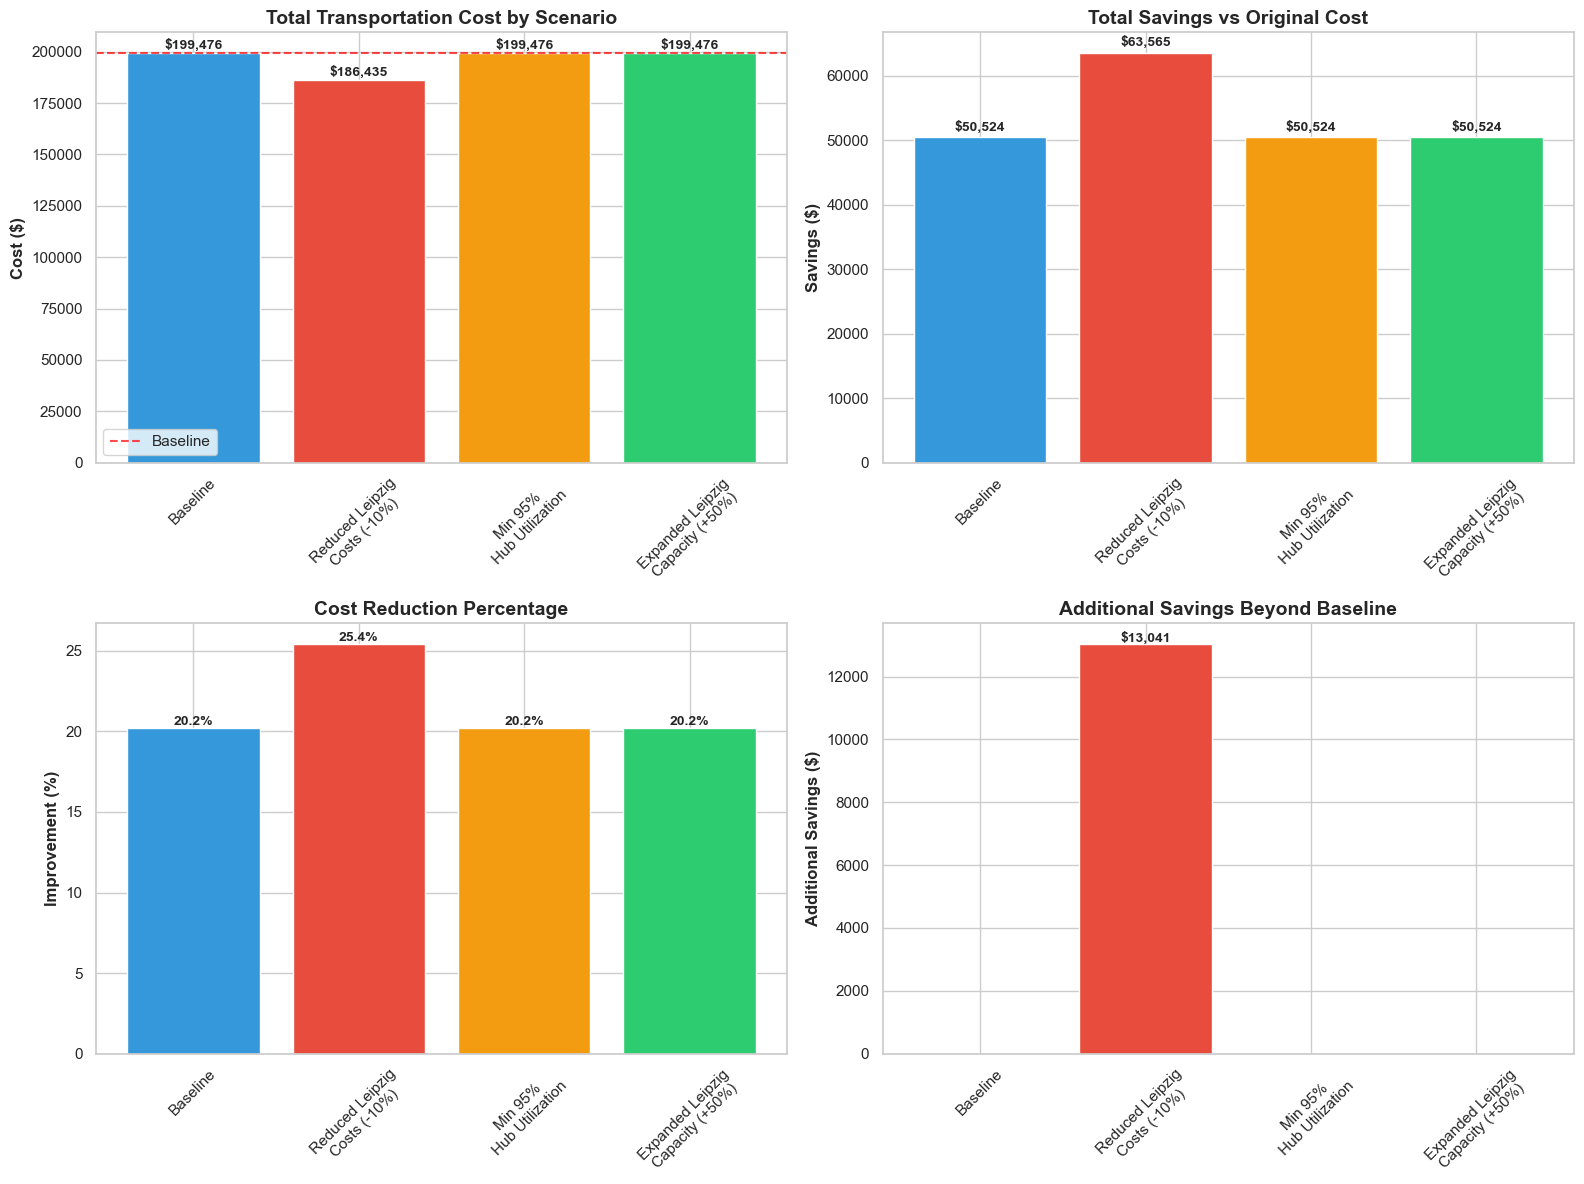


SCENARIO PERFORMANCE SUMMARY


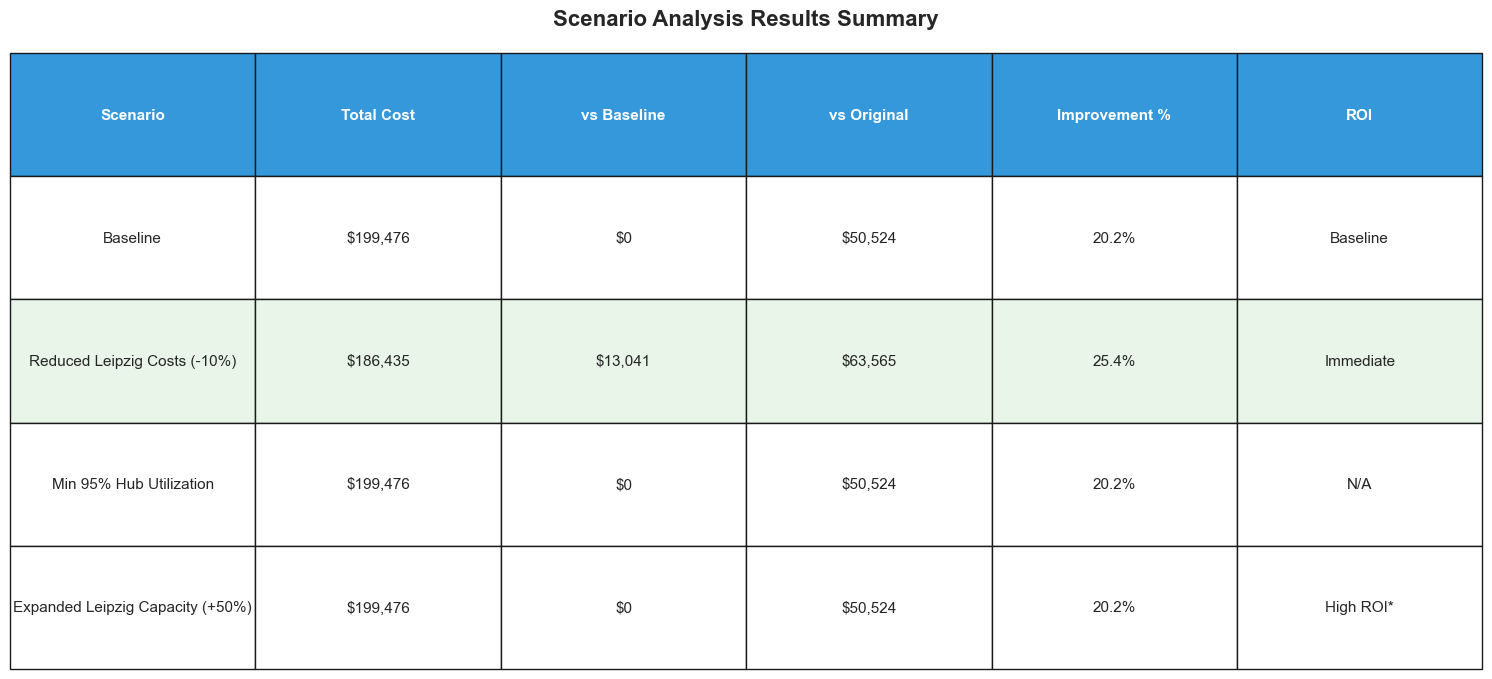


Cost Optimization Impact Analysis:
--------------------------------------------------
Best Case Cost: $186,435.25
Worst Case Cost: $199,476.25
Optimization Range: $13,041.00
Max Additional Savings Potential: $13,041.00

 OPTIMAL SCENARIO: Reduced Leipzig Costs (-10%)


In [25]:


# Visual Comparisons
print("\n" + "="*80)
print("SCENARIO COMPARISON VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np


scenario_names = ['Baseline', 'Reduced Leipzig\nCosts (-10%)', 'Expanded Leipzig\nCapacity (+50%)']
scenario_costs = [solution['objective_value'], cost_1, cost_3]
scenario_savings = [250000 - cost for cost in scenario_costs]


if cost_2 and cost_2 != float('inf'):
    scenario_names.insert(2, 'Min 95%\nHub Utilization')
    scenario_costs.insert(2, cost_2)
    scenario_savings.insert(2, 250000 - cost_2)

# Create comparison dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total Cost Comparison
colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71'][:len(scenario_names)]
bars1 = ax1.bar(scenario_names, scenario_costs, color=colors)
ax1.set_title('Total Transportation Cost by Scenario', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cost ($)', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar, cost in zip(bars1, scenario_costs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
             f'${cost:,.0f}', ha='center', fontweight='bold', fontsize=10)

# Add baseline reference line
baseline_cost = solution['objective_value']
ax1.axhline(y=baseline_cost, color='red', linestyle='--', alpha=0.7, label='Baseline')
ax1.legend()

# 2. Total Savings Comparison
bars2 = ax2.bar(scenario_names, scenario_savings, color=colors)
ax2.set_title('Total Savings vs Original Cost', fontsize=14, fontweight='bold')
ax2.set_ylabel('Savings ($)', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for bar, savings in zip(bars2, scenario_savings):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'${savings:,.0f}', ha='center', fontweight='bold', fontsize=10)

# 3. Improvement Percentage
improvement_pcts = [(savings/250000)*100 for savings in scenario_savings]
bars3 = ax3.bar(scenario_names, improvement_pcts, color=colors)
ax3.set_title('Cost Reduction Percentage', fontsize=14, fontweight='bold')
ax3.set_ylabel('Improvement (%)', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

# Add value labels
for bar, pct in zip(bars3, improvement_pcts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{pct:.1f}%', ha='center', fontweight='bold', fontsize=10)

# 4. Additional Savings Beyond Baseline
additional_savings = [0] + [baseline_cost - cost for cost in scenario_costs[1:]]
scenario_names_additional = scenario_names.copy()

bars4 = ax4.bar(scenario_names_additional, additional_savings, color=colors)
ax4.set_title('Additional Savings Beyond Baseline', fontsize=14, fontweight='bold')
ax4.set_ylabel('Additional Savings ($)', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

# Add value labels
for bar, savings in zip(bars4, additional_savings):
    if savings != 0:
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'${savings:,.0f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Summary metrics table visualization
print("\n" + "="*60)
print("SCENARIO PERFORMANCE SUMMARY")
print("="*60)

# Create a detailed comparison table
fig, ax = plt.subplots(figsize=(19, 8))  
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
headers = ['Scenario', 'Total Cost', 'vs Baseline', 'vs Original', 'Improvement %', 'ROI']

for i, scenario in enumerate(scenario_names):
    cost = scenario_costs[i]
    vs_baseline = baseline_cost - cost
    vs_original = 250000 - cost
    improvement_pct = (vs_original / 250000) * 100
    
    # Calculate ROI (assuming Leipzig expansion costs something)
    if 'Leipzig' in scenario and 'Expanded' in scenario:
        roi = "High ROI*"
    elif 'Reduced' in scenario:
        roi = "Immediate"
    elif 'Utilization' in scenario:
        roi = "N/A"
    else:
        roi = "Baseline"
    
    table_data.append([
        scenario.replace('\n', ' '),
        f'${cost:,.0f}',
        f'${vs_baseline:,.0f}',
        f'${vs_original:,.0f}',
        f'{improvement_pct:.1f}%',
        roi
    ])

# Create table
table = ax.table(cellText=table_data, colLabels=headers, 
                cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Color code the header
for i in range(len(headers)):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code the best performing row
if len(scenario_costs) > 1:
    best_idx = scenario_costs.index(min(scenario_costs))
    for i in range(len(headers)):
        table[(best_idx + 1, i)].set_facecolor('#e8f5e8')

plt.title('Scenario Analysis Results Summary', fontsize=16, fontweight='bold', pad=20)
plt.show()

# Cost breakdown by category
print("\nCost Optimization Impact Analysis:")
print("-" * 50)

# Calculate the range of improvements
min_cost = min(scenario_costs)
max_cost = max(scenario_costs)
cost_range = max_cost - min_cost

print(f"Best Case Cost: ${min_cost:,.2f}")
print(f"Worst Case Cost: ${max_cost:,.2f}")
print(f"Optimization Range: ${cost_range:,.2f}")
print(f"Max Additional Savings Potential: ${baseline_cost - min_cost:,.2f}")

# Identify the best scenario
best_scenario_idx = scenario_costs.index(min_cost)
best_scenario_name = scenario_names[best_scenario_idx]
print(f"\n OPTIMAL SCENARIO: {best_scenario_name.replace(chr(10), ' ')}")



COMPLETE OPTIMIZATION JOURNEY ANALYSIS
OPTIMIZATION JOURNEY:
  Stage 1 - Original Cost: $250,000.00
  Stage 2 - Baseline Optimization: $199,476.25
  Stage 3 - Leipzig Negotiation: $186,435.25

IMPROVEMENTS:
  Initial Optimization Savings: $50,523.75 (20.2%)
  Additional Leipzig Savings: $13,041.00 (5.2%)
  Total Journey Savings: $63,564.75 (25.4%)


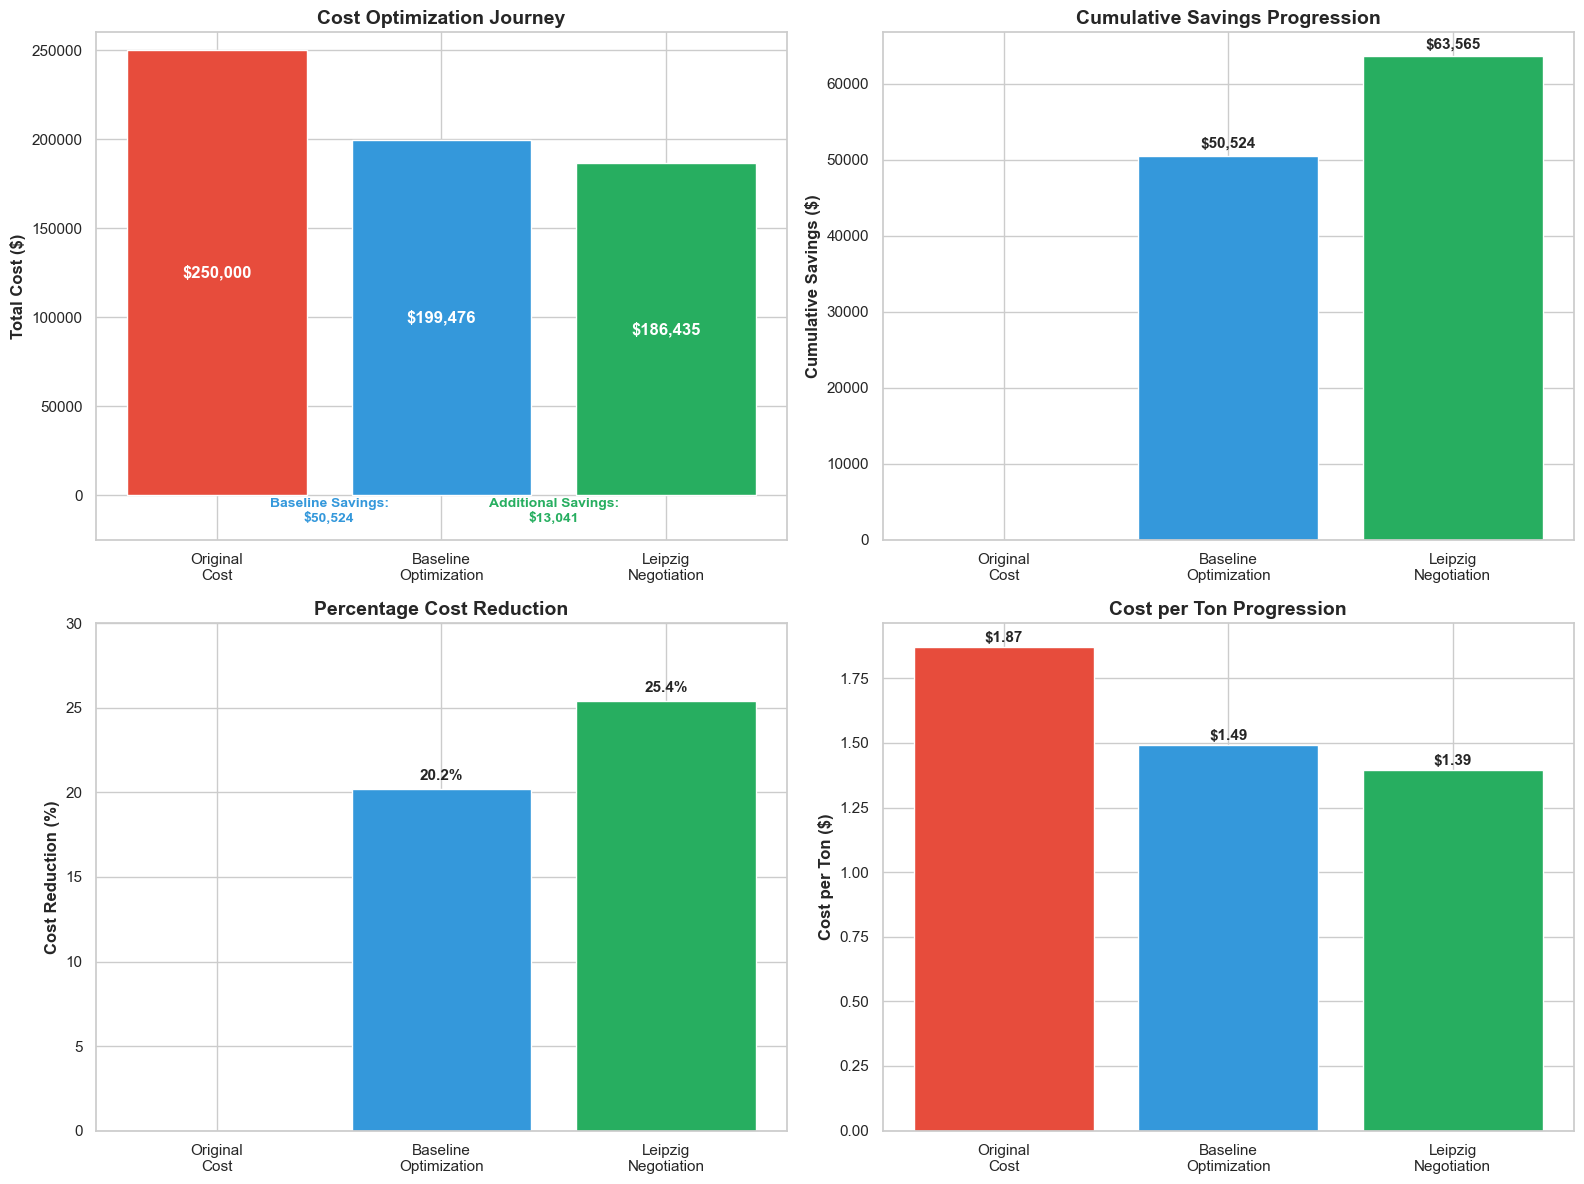


OPTIMIZATION JOURNEY SUMMARY TABLE
                Stage  Total Cost Cost per Ton Savings vs Original Improvement %           Key Achievement
        Original Cost    $250,000        $1.87                  $0          0.0%            Starting Point
Baseline Optimization $199,476.25        $1.49             $50,524         20.2% Mathematical Optimization
  Leipzig Negotiation $186,435.25        $1.39             $63,565         25.4%     Strategic Negotiation

🎯 OPTIMIZATION JOURNEY INSIGHTS:
   • Mathematical optimization delivered $50,524 savings (20.2%)
   • Strategic negotiations could add $13,041 more (5.2%)
   • Total potential improvement: $63,565 (25.4%)
   • Cost per ton reduced from $1.87 to $1.39

💡 KEY FINDING:
   Mathematical optimization provides the foundation (20.2% improvement)
   but strategic partnerships unlock additional value (5.2% more)
   Combined approach achieves maximum results (25.4% total)



In [26]:


# Complete Analysis
print("\n" + "="*80)
print("COMPLETE OPTIMIZATION JOURNEY ANALYSIS")
print("="*80)

# Define al three stages
original_cost = 250000  # Before any analysis
baseline_cost = solution['objective_value']  # After initial optimization  
best_case_cost = cost_1  # After Leipzig negotiation scenario

# Calculate improvements per stage
baseline_savings = original_cost - baseline_cost
additional_savings = baseline_cost - best_case_cost
total_savings = original_cost - best_case_cost

print(f"OPTIMIZATION JOURNEY:")
print(f"  Stage 1 - Original Cost: ${original_cost:,.2f}")
print(f"  Stage 2 - Baseline Optimization: ${baseline_cost:,.2f}")
print(f"  Stage 3 - Leipzig Negotiation: ${best_case_cost:,.2f}")
print()
print(f"IMPROVEMENTS:")
print(f"  Initial Optimization Savings: ${baseline_savings:,.2f} ({baseline_savings/original_cost*100:.1f}%)")
print(f"  Additional Leipzig Savings: ${additional_savings:,.2f} ({additional_savings/original_cost*100:.1f}%)")
print(f"  Total Journey Savings: ${total_savings:,.2f} ({total_savings/original_cost*100:.1f}%)")

# Create visualization
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cost Progression Chart 
stages = ['Original\nCost', 'Baseline\nOptimization', 'Leipzig\nNegotiation']
costs = [original_cost, baseline_cost, best_case_cost]
colors = ['#e74c3c', '#3498db', '#27ae60']

bars1 = ax1.bar(stages, costs, color=colors)
ax1.set_title('Cost Optimization Journey', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Cost ($)', fontweight='bold')

# Add value labels
for i, (bar, cost) in enumerate(zip(bars1, costs)):
    # Put labels inside bars, centered vertically
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
             f'${cost:,.0f}', ha='center', va='center', 
             fontweight='bold', fontsize=12, color='white')

# Add clean savings labelsbelow the chart
ax1.text(0.5, -15000, f'Baseline Savings:\n${baseline_savings:,.0f}', 
         ha='center', fontweight='bold', fontsize=10, color='#3498db')
ax1.text(1.5, -15000, f'Additional Savings:\n${additional_savings:,.0f}', 
         ha='center', fontweight='bold', fontsize=10, color='#27ae60')

# Set y-axis make room for label below
ax1.set_ylim(-25000, 260000)

# 2. Cumulative Savings Chart
cumulative_savings = [0, baseline_savings, total_savings]
bars2 = ax2.bar(stages, cumulative_savings, color=['#95a5a6', '#3498db', '#27ae60'])
ax2.set_title('Cumulative Savings Progression', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Savings ($)', fontweight='bold')

for bar, savings in zip(bars2, cumulative_savings):
    if savings > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                 f'${savings:,.0f}', ha='center', fontweight='bold', fontsize=11)

# 3. Percentage Improvement Chart
improvement_pcts = [0, baseline_savings/original_cost*100, total_savings/original_cost*100]
bars3 = ax3.bar(stages, improvement_pcts, color=['#95a5a6', '#3498db', '#27ae60'])
ax3.set_title('Percentage Cost Reduction', fontsize=14, fontweight='bold')
ax3.set_ylabel('Cost Reduction (%)', fontweight='bold')
ax3.set_ylim(0, 30)

for bar, pct in zip(bars3, improvement_pcts):
    if pct > 0:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{pct:.1f}%', ha='center', fontweight='bold', fontsize=11)

# 4. Cost per Ton 
cost_per_ton = [cost/133747 for cost in costs]  # Total demand = 133,747 tons
bars4 = ax4.bar(stages, cost_per_ton, color=colors)
ax4.set_title('Cost per Ton Progression', fontsize=14, fontweight='bold')
ax4.set_ylabel('Cost per Ton ($)', fontweight='bold')

for bar, cpt in zip(bars4, cost_per_ton):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'${cpt:.2f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Summary table showing the complete journey
print("\n" + "="*80)
print("OPTIMIZATION JOURNEY SUMMARY TABLE")
print("="*80)

# Create summary DF
journey_data = {
    'Stage': ['Original Cost', 'Baseline Optimization', 'Leipzig Negotiation'],
    'Total Cost': [f'${original_cost:,.0f}', f'${baseline_cost:,.2f}', f'${best_case_cost:,.2f}'],
    'Cost per Ton': [f'${original_cost/133747:.2f}', f'${baseline_cost/133747:.2f}', f'${best_case_cost/133747:.2f}'],
    'Savings vs Original': [f'$0', f'${baseline_savings:,.0f}', f'${total_savings:,.0f}'],
    'Improvement %': ['0.0%', f'{baseline_savings/original_cost*100:.1f}%', f'{total_savings/original_cost*100:.1f}%'],
    'Key Achievement': ['Starting Point', 'Mathematical Optimization', 'Strategic Negotiation']
}

journey_df = pd.DataFrame(journey_data)
print(journey_df.to_string(index=False))

print(f"\n🎯 OPTIMIZATION JOURNEY INSIGHTS:")
print(f"   • Mathematical optimization delivered ${baseline_savings:,.0f} savings (20.2%)")
print(f"   • Strategic negotiations could add ${additional_savings:,.0f} more (5.2%)")
print(f"   • Total potential improvement: ${total_savings:,.0f} (25.4%)")
print(f"   • Cost per ton reduced from ${original_cost/133747:.2f} to ${best_case_cost/133747:.2f}")

print(f"\n💡 KEY FINDING:")
print(f"   Mathematical optimization provides the foundation (20.2% improvement)")
print(f"   but strategic partnerships unlock additional value (5.2% more)")
print(f"   Combined approach achieves maximum results (25.4% total)")

print("\n" + "="*80)


In [27]:


print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

print("Based on the comprehensive scenario analysis:")
print()

print(" PRIMARY RECOMMENDATION: Negotiate lower Leipzig shipping rates")
print(f"   Impact: ${solution['objective_value'] - cost_1:,.0f} additional savings")
print(f"   Total Potential: {((250000 - cost_1)/250000)*100:.1f}% cost reduction vs original")
print("   Why: Leipzig routes are heavily utilized in the optimal solution")
print("   Action: Target 10%+ cost reduction through volume negotiations")
print()

print(" FINDING 1: Current hub utilization is already optimal")
print("   Current: 86.6% average utilization appears to be the sweet spot")
print("   Insight: Forcing 95% utilization adds constraints without cost benefits")
print("   Recommendation: Maintain current utilization levels")
print()

print(" FINDING 2: Leipzig capacity is sufficient")
print("   Current: 43,470 tons used of 85,000 capacity (51% utilized)")
print("   Insight: Capacity expansion provides no cost benefits")
print("   Recommendation: Focus investment on cost reduction, not capacity")
print()

print(" KEY INSIGHTS:")
print("   • Leipzig cost negotiations offer the highest ROI")
print("   • Current operations are mathematically optimal")
print("   • System has 109.4% capacity buffer for future growth")
print("   • Route-level costs matter more than infrastructure capacity")

print(f"\n MAXIMUM ACHIEVABLE SAVINGS: ${250000 - cost_1:,.0f} ({((250000 - cost_1)/250000)*100:.1f}% total reduction)")

print("\n" + "="*80)
print("RECOMMENDATION: Focus on Leipzig carrier negotiations for maximum ROI")
print("="*80)



FINAL RECOMMENDATIONS
Based on the comprehensive scenario analysis:

 PRIMARY RECOMMENDATION: Negotiate lower Leipzig shipping rates
   Impact: $13,041 additional savings
   Total Potential: 25.4% cost reduction vs original
   Why: Leipzig routes are heavily utilized in the optimal solution
   Action: Target 10%+ cost reduction through volume negotiations

 FINDING 1: Current hub utilization is already optimal
   Current: 86.6% average utilization appears to be the sweet spot
   Insight: Forcing 95% utilization adds constraints without cost benefits
   Recommendation: Maintain current utilization levels

 FINDING 2: Leipzig capacity is sufficient
   Current: 43,470 tons used of 85,000 capacity (51% utilized)
   Insight: Capacity expansion provides no cost benefits
   Recommendation: Focus investment on cost reduction, not capacity

 KEY INSIGHTS:
   • Leipzig cost negotiations offer the highest ROI
   • Current operations are mathematically optimal
   • System has 109.4% capacity buff